Alertness reduced by 22.0 %
Enter your sleep time and wake time in 24-hour format (e.g., 04:00 for 4 AM):
Enter your sleep time (HH:MM): 02:00
Enter your wake time (HH:MM): 10:00


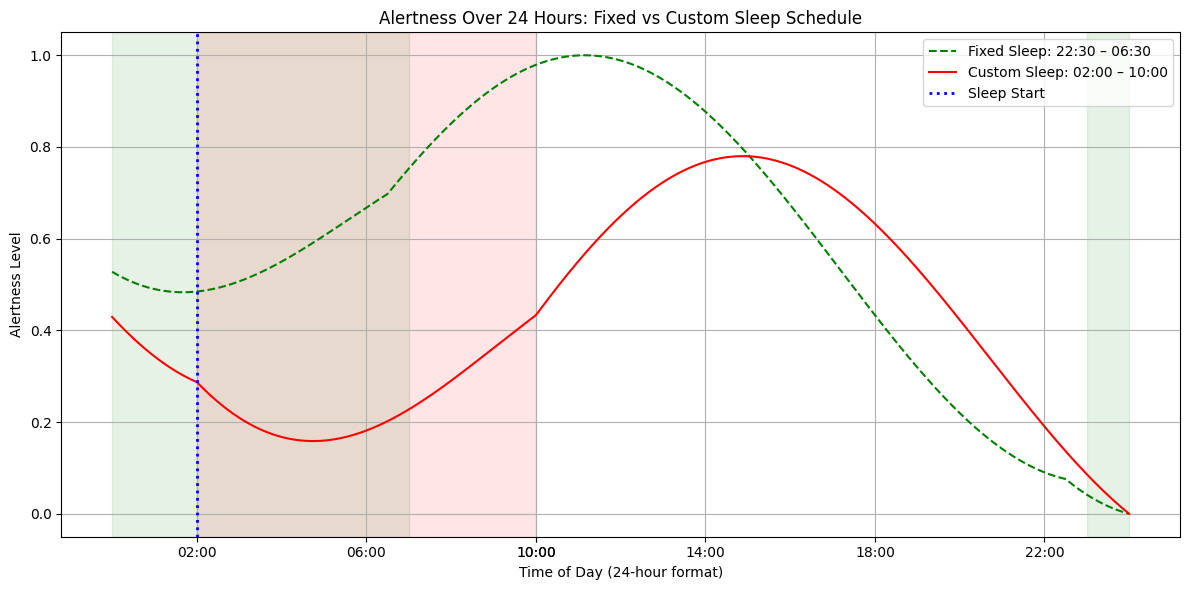

In [ ]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from datetime import datetime

# Parameters
A_base = 0.5 # Baseline alertness level
alpha = 0.058  # Rate of homeostatic decay
beta = 0.9 # Strength of circadian rhythm influence
T_circadian = 24 # Duration of circadian cycle
delta = 0.4  # Suppression of alertness due to sleep
A0 = [A_base] # Starting point for alertness
max_penalty_values = [0.20, 0.22, 0.24, 0.26, 0.28, 0.30]  # Possible alertness penalty values (20-30%) due to suboptimal sleep
max_penalty = np.random.choice(max_penalty_values)  # Randomly choose one penalty for a run
print("Alertness reduced by", max_penalty*100, "%") # Print the penalty used for the run

# Helper function: converts user entered time to decimals
def time_to_decimal(t_str):
    dt = datetime.strptime(t_str.strip(), "%H:%M")
    return dt.hour + dt.minute / 60.0

# Inputs: prompts the user to input sleep and wake times for the model
print("Enter your sleep time and wake time in 24-hour format (e.g., 04:00 for 4 AM):")
custom_sleep_start_input = input("Enter your sleep time (HH:MM): ")
custom_sleep_end_input = input("Enter your wake time (HH:MM): ")

# Converts the entered time to decimals
sleep_start_custom = time_to_decimal(custom_sleep_start_input)
sleep_end_custom = time_to_decimal(custom_sleep_end_input)

# Alertness function (ODE): simulates change in alertness changes over time
# Circadian rhythm component with a phase shift based on wake time (assuming optimal wake time is at 06:30)
def circadian_sleep_drive(A, t, A_base, alpha, beta, T, sleep_start, sleep_end, wake_time, penalty):
    # Phase shift based on wake time - allows us to re-align the circadian rhythm with the user's sleep schedule
    circadian = beta * np.sin(2 * np.pi * (t - (wake_time - 6.5)) / T)

    # Check if the current time is during sleep hours
    sleep_drive = 0
    current_time = t % 24 # Normalise time to a 24-hour clock
    if sleep_start < sleep_end: # If sleeping within the same day
        if sleep_start <= current_time <= sleep_end:
            sleep_drive = -delta
    else: # If sleep goes beyond midnight
        if current_time >= sleep_start or current_time <= sleep_end:
            sleep_drive = -delta

    # ODE for alertness = homeostatic decay + circadian rhythm + alertness suppression
    dA_dt = -alpha * (A[0] - A_base) + circadian + sleep_drive
    return [dA_dt]

# Time vector
time_vector = np.linspace(0, 24, 1000)

# Simulate fixed night sleep for a reference point
sleep_start_fixed = 22.5 # Sleep time - 10:30 PM
sleep_end_fixed = 6.5 # Wake time - 6:30 AM

# Solve the ODE to model alertness without alertness penalty
alertness_fixed = odeint(
    circadian_sleep_drive, A0, time_vector,
    args=(A_base, alpha, beta, T_circadian, sleep_start_fixed, sleep_end_fixed, sleep_end_fixed, 0)
)

# Normalise the values to a 0-1 scale for visualisation
alertness_fixed = (alertness_fixed - np.min(alertness_fixed)) / (np.max(alertness_fixed) - np.min(alertness_fixed))

# Simulate alertness for custom sleep schedule
# Solve the ODE to model alertness with penalty
alertness_custom = odeint(
    circadian_sleep_drive, A0, time_vector,
    args=(A_base, alpha, beta, T_circadian, sleep_start_custom, sleep_end_custom, sleep_end_custom, max_penalty)
)

# Normalise values and apply penalty: reduce max alertness by the chosen value
alertness_custom = (alertness_custom - np.min(alertness_custom)) / (np.max(alertness_custom) - np.min(alertness_custom)) * (1 - max_penalty)

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(time_vector, alertness_fixed, label='Fixed Sleep: 22:30 – 06:30', color='green', linestyle='--') # Fixed schedule alertness
plt.plot(time_vector, alertness_custom, label=f'Custom Sleep: {custom_sleep_start_input} – {custom_sleep_end_input}', color='red') # Custom schedule alertness

# Highlight sleep time - fixed schedule
plt.axvspan(23, 24, color='green', alpha=0.1)
plt.axvspan(0, 7, color='green', alpha=0.1)

# Highlight sleep time - custom schedule
if sleep_start_custom < sleep_end_custom:
    plt.axvspan(sleep_start_custom, sleep_end_custom, color='red', alpha=0.1)
else:
    plt.axvspan(sleep_start_custom, 24, color='red', alpha=0.1)
    plt.axvspan(0, sleep_end_custom, color='red', alpha=0.1)

# Create dynamic x-axis ticks: every 4 hours, starting from user's wake time
tick_base = int(sleep_end_custom)  # User’s wake time (rounded down)
ticks = [(tick_base + i) % 24 for i in range(0, 25, 4)]  # every 4 hours, modulo 24 to wrap around

# Convert to readable labels in 24-hour format (HH:MM)
labels = []
for t in ticks:
    hour = int(t)
    minute = 0
    labels.append(f"{hour:02d}:{minute:02d}")

plt.title('Alertness Over 24 Hours: Fixed vs Custom Sleep Schedule')
plt.xlabel('Time of Day (24-hour format)')
plt.ylabel('Alertness Level')
plt.xticks(ticks, labels)
plt.axvline(sleep_start_custom, color='blue', linestyle=':', linewidth=2, label='Sleep Start') # Add a vertical line at the user's custom sleep start time
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()